In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms as transforms
from torchvision.datasets import CIFAR10
import torch.nn as nn
import torch.optim as optim
import sys
import pytorch_lightning as pl
import os


In [2]:
#adjustable hparams
batch_size = 64
lr = 1e-3
max_epochs = 1
latent_dim = 128
#change this to 'cuda'
device = 'cpu'


dataset_path = '/Users/gpnuser/Documents/Horos Data/Jas_Pycharm/VAE'
loss_log = np.zeros(max_epochs,)
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=None, profile=None, sci_mode=False)
np.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=None, suppress=True, nanstr=None, infstr=None, formatter=None, sign=None, floatmode=None, legacy=None)

In [3]:

stride = 2
padding = 1
#dont touch this stuff
# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = CIFAR10(root=dataset_path, train=True, transform=transform, download=True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=dataset_path, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)


def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)


Files already downloaded and verified


Global seed set to 42


Files already downloaded and verified


In [4]:
x = torch.load('in_imagetwo.pt')
#plt.imshow(x[0].permute(1,2,0))

In [9]:
# layer architecture
class Autoencoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=stride, padding=padding),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=stride, padding=padding),           # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=stride, padding=padding),           # [batch, 48, 4, 4]
            nn.ReLU(),
# 			nn.Conv2d(48, 96, 4, stride=stride, padding=padding),           # [batch, 96, 2, 2]
#             nn.ReLU(),
        )
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(96, 48, 4, stride=stride, padding=padding),  # [batch, 48, 4, 4]
#             nn.ReLU(),
			nn.ConvTranspose2d(48, 24, 4, stride=stride, padding=padding),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=stride, padding=padding),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=stride, padding=padding),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
  #      plt.imshow(reconstructed[0].permute(1,2,0))
        return latent, reconstructed

    def get_loss(self, batch):
        x, _ = batch  # We do not need the labels
        x_hat = self.forward(x)
        loss = nn.functional.mse_loss(x, x_hat)
        loss = torch.mean(loss)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.get_loss(batch)
        #implement log loss
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.get_loss(batch)
        #implement log loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)

    def represent(self):
        print('encoder is:')
        print(self.encoder)
        print('decoder is:')
        print(self.decoder)



In [10]:
if __name__ == "__main__":
    net = Autoencoder()
    net.represent()
    trainer = pl.Trainer()
    trainer.fit(net, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/gpnuser/Documents/Horos Data/Jas_Pycharm/PycharmProject/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/Users/gpnuser/Documents/Horos Data/Jas_Pycharm/PycharmProject/lib/python3.9/site-packages/pytorch_lightning/core/optimizer.py:183: UserWarning: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer
  rank_zero_warn(

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 23.7 K
1 | decoder | Sequential | 23.7 K
---------------------------------------
47.4 K    Trainable params
0         Non-trainable params
47.4 K    Total params
0.189     Total estimated model params size (MB)


encoder is:
Sequential(
  (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
)
decoder is:
Sequential(
  (0): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): ConvTranspose2d(24, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): ConvTranspose2d(12, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): Sigmoid()
)


Sanity Checking: 0it [00:00, ?it/s]

AttributeError: 'tuple' object has no attribute 'size'

tensor([[0.5031, 0.5030, 0.5037,  ..., 0.5028, 0.5038, 0.5021],
        [0.5021, 0.5031, 0.5028,  ..., 0.5032, 0.5025, 0.5033],
        [0.5033, 0.5008, 0.5050,  ..., 0.5008, 0.5048, 0.5003],
        ...,
        [0.5020, 0.5030, 0.5025,  ..., 0.5028, 0.5030, 0.5034],
        [0.5033, 0.5009, 0.5050,  ..., 0.5009, 0.5050, 0.5006],
        [0.5010, 0.5042, 0.5001,  ..., 0.5043, 0.5000, 0.5030]])


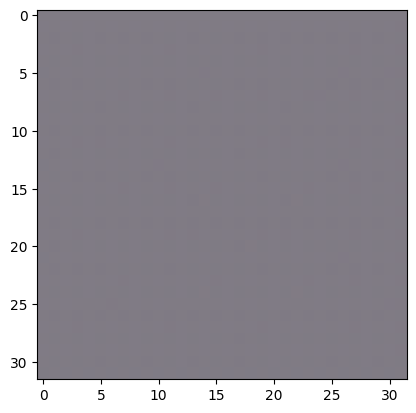

In [53]:
middle, end = net.forward(x)
end = end[0].detach()
plt.imshow(end.permute(1,2,0))
print(end[0])

